In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

sys.path.append('../code/')
from interpolation import cfl_interpolation
from diusst_eulera import diusst_eulera
from diusst_eulerb import diusst_eulerb
from diusst_rk4a import diusst_rk4a
from diusst_rk4b import diusst_rk4b
from diusst_eulerc import diusst_eulerc

## Settings

In [12]:
# Fit parameters
param_names = ['kappa', 'mu', 'attenu', 'k0', 'gamma']
parama = np.array([1e-4, 1e-4, 2.5])
paramb = np.array([3e-4, 1e-4, 2.5])
paramc = np.array([2e-4, 1e-4, 2.5, 0.95, 2])
param_max = np.array([7e-4, 1e-4, 2.5])

# DIUSST model
scheme = 'euler'
dz0 = 0.10
ngrid = 50
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_ssterr03-10_humid10.csv'
data_interval = [1149,1471]

## Data

In [3]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[data_interval[0]:data_interval[1]]

# interpolate to meet CFL condition
data, dtlist = cfl_interpolation(data_orig, dz0=dz0, ngrid=ngrid,
        a=0, b=1, k_eddy_max=param_max[0], maxwind=maxwind,)
        #save=output_path+timestamp+'_'+run_id)


# extract data
ftemp = np.mean(data['ftemp'].to_numpy(np.float64))
sst_data = data['sst'].to_numpy(np.float64) - data['ftemp'].to_numpy(np.float64)
sst_err = data['sst_err'].to_numpy(np.float64)
times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

+++ Variable time-step interpolation +++
Interpolated dataset has 70257 time steps with average length 6.615 s.
Constant dt interpolation would require dt = 0.972 s --> 294987 steps.
Computation time will be reduced by 76.183 %
++++++++++++++++++++++++++++++++++++++++


## Run models

In [4]:
simstart = time.time()

kappa, mu, attenu = parama
eul_a = diusst_eulera(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

/home/reykiboy/Documents/diusst_public/FINAL/../code/diusst_funcs.py:43: RuntimeWarning: overflow encountered in multiply
  b[2:-1] = (a[3:] - 2*a[2:-1] + a[1:-2]) * deriv1[2:-1]**2 + (a[3:]-a[1:-2])*0.5*deriv2[2:-1]
/home/reykiboy/Documents/diusst_public/FINAL/../code/diusst_funcs.py:43: RuntimeWarning: invalid value encountered in add
  b[2:-1] = (a[3:] - 2*a[2:-1] + a[1:-2]) * deriv1[2:-1]**2 + (a[3:]-a[1:-2])*0.5*deriv2[2:-1]
/home/reykiboy/Documents/diusst_public/FINAL/diusst_eulera.py:114: RuntimeWarning: invalid value encountered in add
  T[n] = T[n-1] + dt[n-1] * (


2.54310941696167


In [71]:
simstart = time.time()

kappa, mu, attenu = paramb
eul_b = diusst_eulerb(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

2.2237727642059326


In [89]:
simstart = time.time()

kappa, mu, attenu, k0, gamma = paramc
eul_c = diusst_eulerc(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=5e-4, mu=0.01, attenu=2.5, k0=0.99, gamma=10,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

4.341660976409912


In [7]:
simstart = time.time()

kappa, mu, attenu = parama
rk4_a = diusst_rk4a(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

6.529466152191162


In [8]:
simstart = time.time()

kappa, mu, attenu = paramb
rk4_b = diusst_rk4b(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

7.7790961265563965


[Text(0.5, 1.0, 'SST-ftemp')]

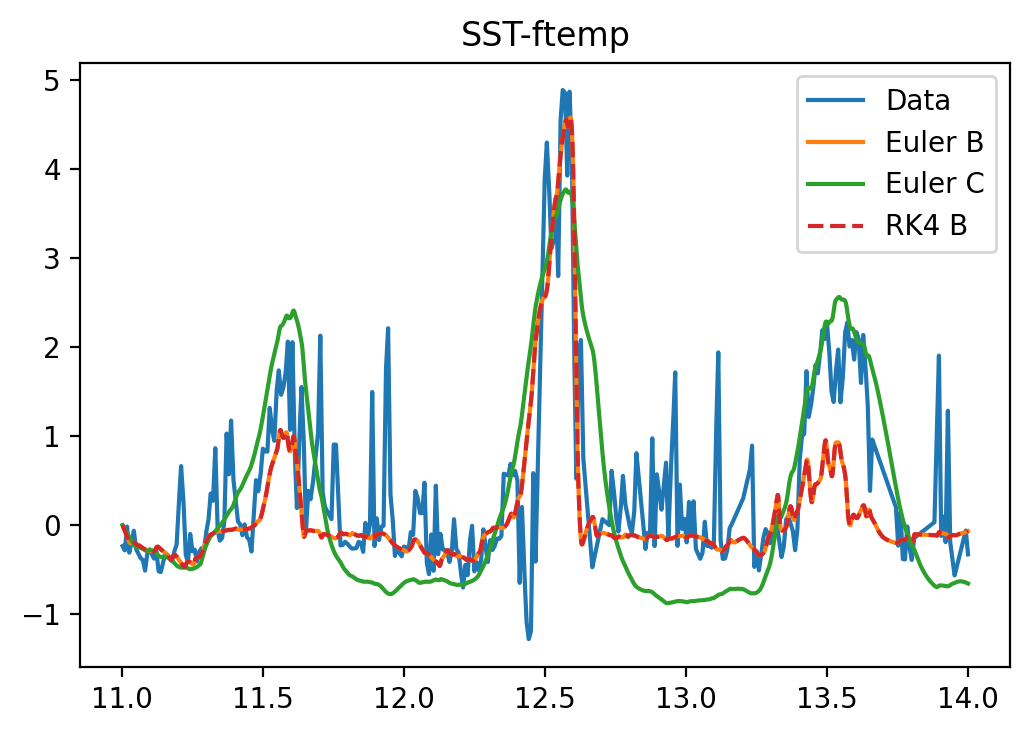

In [90]:
fig, ax = plt.subplots(dpi=200)
ax.plot(times/86400,sst_data, label='Data')
#ax.plot(times/86400,eul_a[0][:,0]-ftemp,label='Euler A')
ax.plot(times/86400,eul_b[0][:,0]-ftemp,label='Euler B')
ax.plot(times/86400,eul_c[0][:,0]-ftemp,label='Euler C')
#ax.plot(times/86400,rk4_a[0][:,0]-ftemp,'--',label='RK4 A')
ax.plot(times/86400,rk4_b[0][:,0]-ftemp,'--',label='RK4 B')

ax.legend()
ax.set(title='SST-ftemp')

No handles with labels found to put in legend.


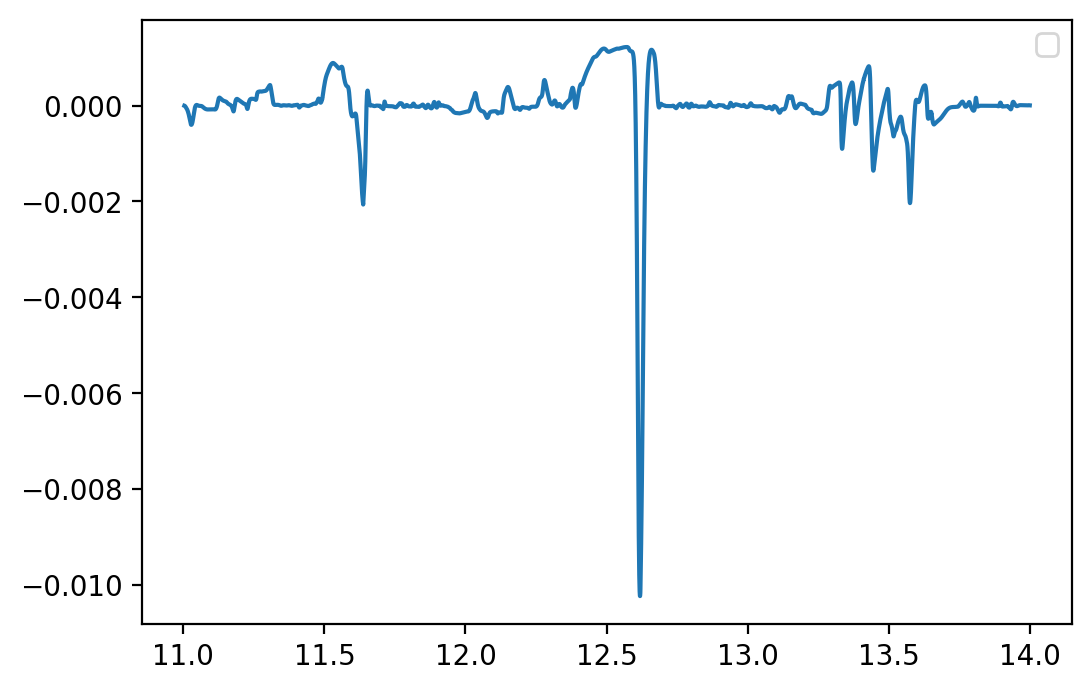

In [10]:
fig, ax = plt.subplots(dpi=200)
#ax.plot(times/86400,sst_data, label='Data')
#ax.plot(times/86400,eul_a[0][:,0]-ftemp,label='Euler A')
ax.plot(times/86400,eul_b[0][:,0]-rk4_b[0][:,0])
#ax.plot(times/86400,rk4_a[0][:,0]-ftemp,'--',label='RK4 A')
#ax.plot(times/86400,rk4_b[0][:,0]-ftemp,lw=0.5,label='RK4 B')
ax.legend()


[(-5.0, 0.0)]

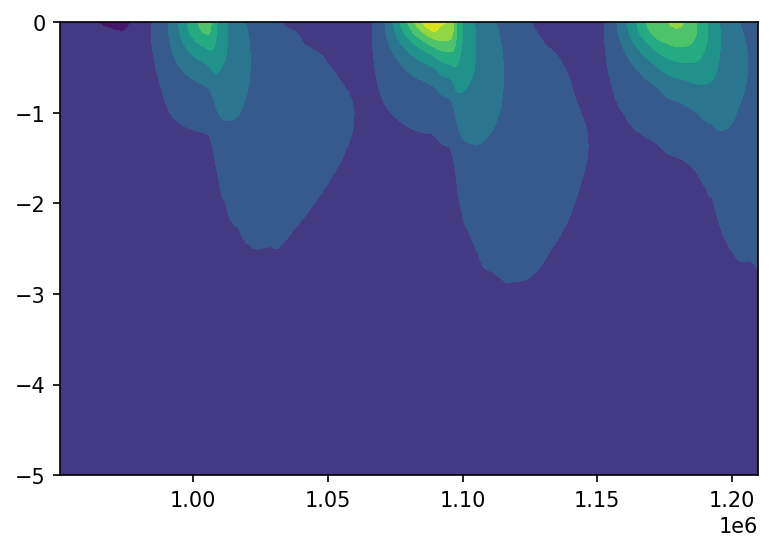

In [76]:
fig, ax = plt.subplots(dpi=150)
ax.contourf(times,eul_c[1],eul_c[0].transpose(),levels=10)
ax.set(ylim=(-5,0))